In [1]:
# Diabetic Foot Ulcer Segmentation

In [2]:
# lets get the data from here:
# https://github.com/uwm-bigdata/wound-segmentation/tree/master/data/Foot%20Ulcer%20Segmentation%20Challenge

In [3]:
import os
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Any, Callable, KeysView, List, Optional, Tuple, Union

import git
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL.Image import Image
import torch as th
import torchvision

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, slide, valley
from fastai.data.block import DataBlock
from fastai.data.core import DataLoaders
from fastai.data.transforms import FuncSplitter, IntToFloatTensor, get_image_files
from fastai.layers import Mish
from fastai.learner import Learner
from fastai.metrics import Dice
from fastai.optimizer import ranger
from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.learner import unet_learner

In [4]:
def download_data(data_dir):
    git.Git(data_dir).clone("https://github.com/uwm-bigdata/wound-segmentation")

In [5]:
def get_data_dir() -> Path:
    data_dir = Path("../data")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir, exist_ok=True)
    
    if "wound-segmentation" not in os.listdir(data_dir):
        download_data(data_dir)
        
    dfu_dataset_path = data_dir / "wound-segmentation" / "data" / "Foot Ulcer Segmentation Challenge"
    return dfu_dataset_path

In [6]:
def get_all_data(dfu_dataset_path: str) -> Callable:
    train_path = dfu_dataset_path / "train"
    train_image_path = train_path / "images"
    val_path = dfu_dataset_path / "validation"
    val_image_path = val_path / "images"
    train_images = get_image_files(train_image_path)
    val_images = get_image_files(val_image_path)
    trainval = train_images + val_images
    def all_data(path) -> List[Path]:
        return trainval
    return all_data

In [7]:
def get_datablock(codes: List[str], get_data: Callable, batch_tfms: Optional[List] = None) -> DataBlock:
    def is_valid() -> Callable:
        def _func(x): return "/validation/" in str(x)
        def _inner(o, **kwargs): return FuncSplitter(_func)(o)
        return _inner
    
    get_msk = lambda o: o.parent.parent / 'labels' / f'{o.stem}{o.suffix}'

    transforms = list(batch_tfms) if batch_tfms else []
    transforms.append(IntToFloatTensor(div_mask=255))
                               
    return DataBlock(
        blocks=(ImageBlock, MaskBlock(codes)),
        get_items=get_data,
        splitter=is_valid(),
        get_y=get_msk,
        batch_tfms=transforms
    )

In [8]:
def get_dataloader(codes: List[str], datablock: DataBlock, batch_size: int = 1) -> DataLoaders:
    datablock = datablock.dataloaders(None, bs=batch_size)
    datablock.vocab = codes
    return datablock

In [9]:
def get_learner(dataloader: DataLoaders, backbone: Union[str, Callable], metrics: Optional[List] = None,
                weights_path: Optional[str] = None, optimizer: Optional[Callable] = None):
    learner = unet_learner(dataloader, backbone, metrics=metrics, self_attention=True, act_cls=Mish, opt_func=optimizer)
    if weights_path:
        learner.load(weights_path)
    return learner

In [10]:
def decode_preds(preds) -> np.ndarray:
    pred = preds[0][0]
    pred_arx = pred.argmax(dim=0)
    image = (pred_arx.numpy() * 255).astype(np.uint8)
    return image

In [11]:
def predict(image_path, learner) -> np.ndarray:
    dl = learner.dls.test_dl([image_path])
    preds = learner.get_preds(dl=dl)
    return decode_preds(preds)

In [12]:
def load_model_inference(data: Callable, backbone: Union[str, Callable], weights_path: str, **kwargs) -> Learner:
    return load_model(data=data, backbone=backbone, weights_path=weights_path)

In [13]:
def load_model_training(data: Callable, batch_size: int, backbone: Union[str, Callable], metrics: List, optimizer: Callable,
                        batch_tfms: Optional[List] = None, weights_path: Optional[str] = None, **kwargs) -> Learner:
    return load_model(data=data, backbone=backbone, metrics=metrics, optimizer=optimizer, weights_path=weights_path)

In [14]:
def load_model(data: Callable, batch_size: int = 1, backbone = Union[str, Callable], metrics: Optional[List] = None,
               optimizer: Optional[Callable] = None, weights_path: Optional[str] = None, batch_tfms: Optional[List] = None) -> Learner:
    codes = ["Void", "Wound"]
    datablock = get_datablock(codes=codes, get_data=data, batch_tfms=batch_tfms)
    dataloader = get_dataloader(codes=codes, datablock=datablock, batch_size=batch_size)
    model = get_learner(dataloader=dataloader, backbone=backbone, metrics=metrics, weights_path=weights_path, optimizer=optimizer)
    return model

In [15]:
def load_image(path: Union[os.PathLike, Any]) -> Any:
    if isinstance(path, Image):
        return path
    elif isinstance(path, os.PathLike):
        img = PIL.Image.open(path)
    else:
        img = PIL.Image.fromarray(path)

    return img.convert("RGBA")

In [16]:
def plot_all(source: Union[str, Image], mask: Image):
    source_img = load_image(source)
    mask_img = load_image(mask)
    combined = PIL.ImageChops.multiply(source_img, mask_img)
    f, axarr = plt.subplots(1,3, figsize=(20,20))
    axarr[0].imshow(source_img)
    axarr[1].imshow(mask_img)
    axarr[2].imshow(combined)
    plt.show()

In [17]:
def get_metrics(void_code: int = 0) -> List:
    def acc_dfu(inp, targ):
        targ = targ.squeeze(1)
        mask = targ != void_code
        result = (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
        return result.nan_to_num()
    return [acc_dfu, Dice]

In [18]:
@dataclass
class Experiment:
    data: Callable
    backbone: Union[str, Callable]
    optimizer: Callable
    weights_path: Optional[str]
    input_size: int
    batch_size: int
    batch_tfms: List
    metrics: List[Callable]

    @property
    def name(self) -> str:
        return f"{self.today}-{self.backbone.__name__}-{self.input_size}-{self.optimizer.__name__}"
    
    @property
    def today(self) -> str:
        return datetime.today().strftime('%Y-%m-%d')
    
    # allows splatting with **payload
    def keys(self) -> KeysView[str]:
        return self.__dict__.keys()

    # allows splatting with **payload
    def __getitem__(self, key: str) -> Any:
        return self.__dict__.__getitem__(key)

In [19]:
dfu_dataset_path = get_data_dir()

In [20]:
experiment = {}
experiment["data"] = get_all_data(dfu_dataset_path=dfu_dataset_path)
experiment["metrics"] = get_metrics()
experiment["backbone"] = torchvision.models.resnet.resnet34
experiment["optimizer"] = ranger
experiment["weights_path"] = None # fresh finetuning
experiment["input_size"] = 256 # images are 512
experiment["batch_size"] = 64
experiment["batch_tfms"] = [
    aug_transforms(size=(experiment["input_size"], experiment["input_size"]))
] # faster iterations

In [21]:
x = Experiment(**experiment)
print(f"Preparing Experiment: {x.name}")
model = load_model_training(**x)

Preparing Experiment: 2022-06-26-resnet34-256-ranger


/home/madhavajay/fastai-course-2022/.venv/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0003311311302240938, slide=0.0010000000474974513)

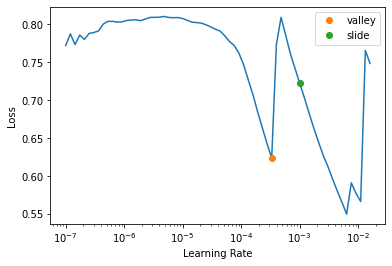

In [22]:
model.lr_find(suggest_funcs=(valley, slide))

In [27]:
lr = 1e-3

In [28]:
model.fit_flat_cos(1, slice(lr))

epoch,train_loss,valid_loss,acc_dfu,dice,time
0,0.015635,0.012168,0.735697,0.808634,03:24


In [ ]:
model.fit_flat_cos(3, slice(lr))